# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [72]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM, imbalance
from util.fg_data import clean, get_data

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_palette('colorblind')
from datetime import datetime as dt
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [73]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   dist           18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [74]:
# df = pd.read_csv('../data/field_goals.csv', index_col=0)
# df.drop(['kicks','age','form'], axis=1, inplace=True)
# df.info()

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker?

In [75]:
# T = 'iced'
# drop = []

T = 'altitude'
drop = ['turf']
# df[on] = df[on].astype(bool)

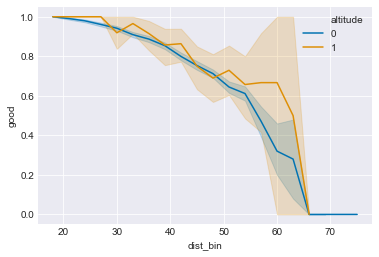

In [76]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=T, data=df_)

In [77]:
print(df[T].value_counts())

0    18168
1      635
Name: altitude, dtype: int64


In [78]:
df

,good,dist,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,2000,17,22,0,10,1,0,0,1,0,1
2185,1,27,2000,17,22,0,10,1,0,0,1,0,1
4565,1,36,2000,17,26,0,13,0,0,1,0,0,5
8564,1,24,2000,17,16,0,16,1,0,0,1,1,1
8628,1,40,2000,17,16,0,16,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,0,0,0,0,0,0,0,1
865338,1,21,2019,3,18,0,11,0,0,0,0,0,2
868268,1,22,2019,3,6,0,7,1,0,0,1,0,1


## One-to-many CEM with weighted linear regression - relaxed on distance
## k-k CEM with linear regression - relaxed on distance
## One-to-many CEM with weighted t-test / z-test (for altitude only on long range kicks?)
## k-k CEM with t-test / z-test (as above)
## One-to-many with Bayesian difference of means (May not be possible with beta-binomial conjugacy) (as above)
## k-k CEM with Bayesian difference of means (as above)

## Weighted log-linear regression at different coarsenings

### We setup our cem matcher which will calculate H (including bin edges) for imbalance calculations if it is not provided explicitly.

In [100]:
continuous = ['dist', 'year', 'seasons', 'temperature', 'wind', 'pressure']
cem = CEM(df, T, 'good', continuous)
# cem = CEM(df, T, 'good', continuous)

Calculating H, this may take a few minutes.
Unable to allocate 6.87 GiB for an array with shape (10, 10, 10, 10, 10, 4, 4, 4, 4, 4, 9) and data type float64
Unable to allocate 11.1 GiB for an array with shape (11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 9) and data type float64


In [80]:
# Put this in the CEM class somewhere
# rows = []
# cont_bins = range(1,10)
# weights = cem.match(coarsening)
# for H in cont_bins:
#     # we use H bins for continuous variables when evaluating imbalance
#     original_imbalance, (bins, ranges) = imbalance(cem.data.drop('good', axis=1), T, continuous=continuous, H=H, retargs=True)
#     rows.append(pd.Series({'data':'raw', 'measure':original_imbalance, 'H': H}))
#     cem_imbalance = imbalance(cem.data.drop('good', axis=1).loc[weights>0, :], T, bins=bins, ranges=ranges) # same bins and ranges as raw data histogram
#     rows.append(pd.Series({'data':'CEM', 'measure':cem_imbalance, 'H': H}))
# imbalance = pd.DataFrame.from_records(rows)
# ax = sns.lineplot(x='H', y='measure', hue='data', data=imbalance, markers=True, style='data')
# ax.set_title('L1 score for different continuous binnings')

In [81]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 6, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': 4, 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': 5, 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 6, 'cut': 'cut'},
 'seasons': {'bins': 4, 'cut': 'qcut'},
 'temperature': {'bins': 5, 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [93]:
#model
# relax_on = [('dist', range(2,4), 'cut'), ('seasons', range(3,5), 'cut')]
relax_on = [('dist', range(4,11), 'cut')]
# formula = 'good ~ ' + ' + '.join(df.drop(['good']+drop, axis=1).columns)
# formula = 'good ~ ' + ' + '.join(df.drop(['good']+drop, axis=1).columns) + f' + dist*{T}'
formula = f'good ~ {T} + dist*{T} + dist'
# formula = f'good ~ {T}'
regressed, relaxed = cem.regress(coarsening, relax_on, formula=formula, drop=drop, include_relax=True, family=sm.family.Binomial())

0%|          | 0/7 [00:00<?, ?it/s]Regressing with 7 different pd.cut binnings on "dist"

100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


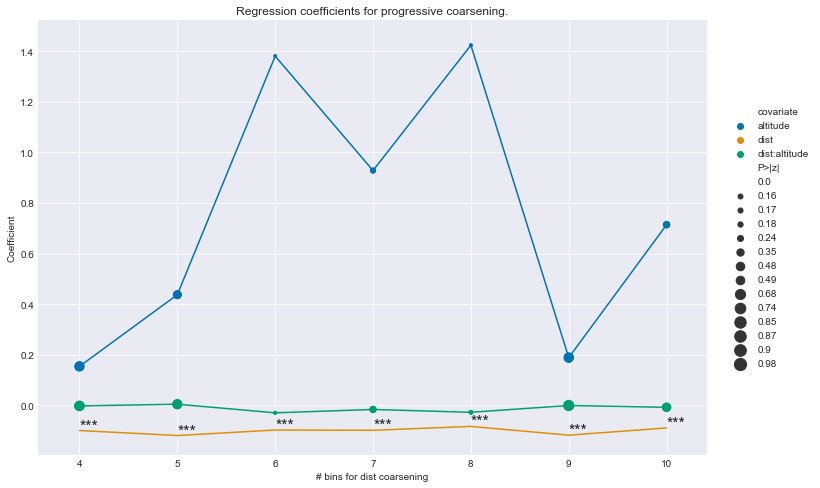

In [99]:
# regressed.plot(include=[T, f'dist:{T}', 'dist'], stars=True, legend='brief')
regressed.plot(include=[T, f'dist:{T}', 'dist'], stars=True, legend='full')

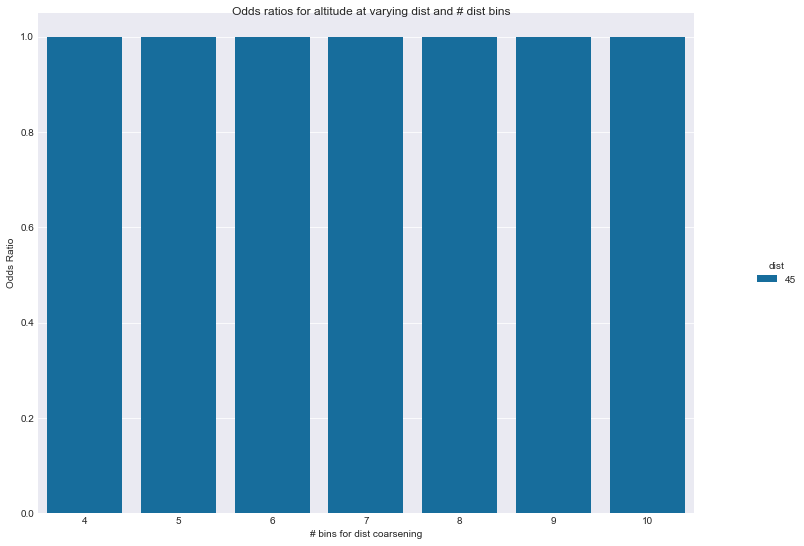

In [95]:
# _ = regressed.odds_ratios('dist', [25,35,45,55,65])
_ = regressed.odds_ratios('dist', [45])

In [96]:
relaxed.coarsenings

imbalance measure  \
var  n_bins                      
dist 4        0.599645      l1   
     5        0.535414      l1   
     6        0.598953      l1   
     7        0.568702      l1   
     8        0.561371      l1   
     9        0.545427      l1   
     10       0.528443      l1   

                                                    coarsening    bins  \
var  n_bins                                                              
dist 4       {'dist': {'bins': 4, 'cut': 'cut'}, 'year': {'...  138240   
     5       {'dist': {'bins': 5, 'cut': 'cut'}, 'year': {'...  172800   
     6       {'dist': {'bins': 6, 'cut': 'cut'}, 'year': {'...  207360   
     7       {'dist': {'bins': 7, 'cut': 'cut'}, 'year': {'...  241920   
     8       {'dist': {'bins': 8, 'cut': 'cut'}, 'year': {'...  276480   
     9       {'dist': {'bins': 9, 'cut': 'cut'}, 'year': {'...  311040   
     10      {'dist': {'bins': 10, 'cut': 'cut'}, 'year': {...  345600   

             treatment_0  treatment_1  \
var  n_bins                             
dist 4              1160          422   
     5               992          399   
     6               931          392   
     7               786          378   
     8               759          361   
     9               691          336   
     10              588          323   

                                                    univariate  
var  n_bins                                                     
dist 4       <matching.cem.UnivariateBalance object at 0x00...  
     5       <matching.cem.UnivariateBalance object at 0x00...  
     6       <matching.cem.UnivariateBalance object at 0x00...  
     7       <matching.cem.UnivariateBalance object at 0x00...  
     8       <matching.cem.UnivariateBalance object at 0x00...  
     9       <matching.cem.UnivariateBalance object at 0x00...  
     10      <matching.cem.UnivariateBalance object at 0x00...

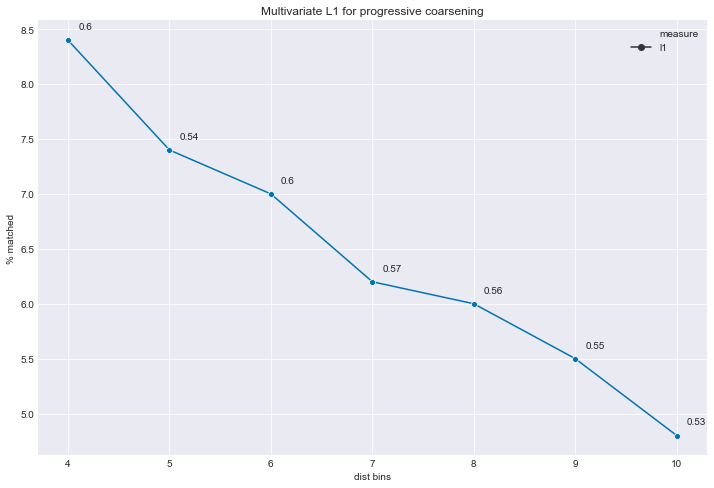

In [97]:
_ = relaxed.plot('multivariate')

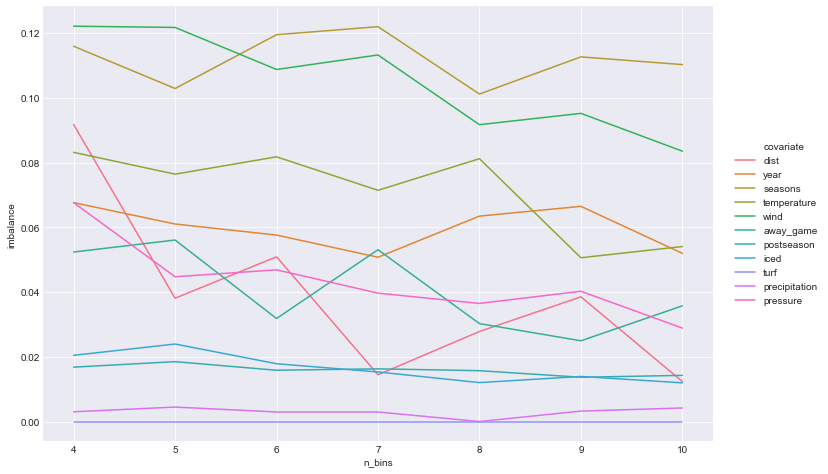

In [98]:
relaxed.plot('univariate')

## Bayesian A/B test at different coarsenings and different distances?

## Model - BOGUS: This kind of modelling doesn't take into account stratum sizes. Will need to weight them if you want to use it.

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [ ]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

In [ ]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

In [ ]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

In [ ]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

In [ ]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')